In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
import utils

In [22]:
#open and combine all data
base_key = 'BTCUSD'
other_keys =('ETHUSD', 'SOLUSD', 'DOTUSD', 'ADAUSD', 'ALGOUSD')
full_df = pd.read_csv(os.path.join('..', 'data', 'scraped_OHLC_7-13-2023', base_key+'.csv'))
full_df['dtime'] = pd.to_datetime(full_df['dtime'], format='%Y-%m-%d %H:%M:%S')
full_df.set_index('dtime', inplace = True)
full_df.drop(columns=['time'], inplace=True)
full_df = full_df.add_prefix(base_key+'_')

for key in other_keys:
    price_data = pd.read_csv(os.path.join('..', 'data', 'scraped_OHLC_7-13-2023', key+'.csv'))
    price_data['dtime'] = pd.to_datetime(price_data['dtime'], format='%Y-%m-%d %H:%M:%S')
    price_data.set_index('dtime', inplace = True)
    price_data.drop(columns=['time'], inplace=True)
    price_data = price_data.add_prefix(key+'_')
    full_df = pd.merge_asof(full_df, price_data, left_index=True, right_index=True, direction='nearest')

full_df.dropna(inplace=True, axis=0, how='all')

#normalize 'vwap', 'volume', 'count' data
norm_df = full_df.copy()
for key in full_df.keys():
    if key.endswith(('vwap', 'volume', 'count')):
        norm_df[key] = (full_df[key] - full_df[key].mean()) / full_df[key].std()

In [23]:
norm_df.values.shape    

(630528, 42)

In [24]:
norm_df

,BTCUSD_open,BTCUSD_high,BTCUSD_low,BTCUSD_close,BTCUSD_vwap,BTCUSD_volume,BTCUSD_count,ETHUSD_open,ETHUSD_high,ETHUSD_low,...,ADAUSD_vwap,ADAUSD_volume,ADAUSD_count,ALGOUSD_open,ALGOUSD_high,ALGOUSD_low,ALGOUSD_close,ALGOUSD_vwap,ALGOUSD_volume,ALGOUSD_count
dtime,,,,,,,,,,,,,,,,,,,,,
2022-04-13 17:33:00,41054.5,41054.5,41054.5,41054.5,2.777088,-0.199009,-0.329345,3077.99,3077.99,3077.99,...,3.003636,0.136680,0.043855,0.74163,0.74163,0.74163,0.74163,-0.608540,-0.089799,-0.290110
2022-04-13 17:34:00,41054.5,41054.5,41000.0,41000.0,2.773286,-0.182037,0.240725,3077.99,3078.00,3076.14,...,3.002958,-0.143306,-0.226992,0.73939,0.73939,0.73939,0.73939,3.950679,-0.089220,-0.052402
2022-04-13 17:35:00,41000.0,41001.6,40991.8,41001.5,2.767672,-0.190197,-0.129820,3075.37,3075.40,3075.37,...,-1.000672,-0.143450,-0.317274,0.73939,0.73939,0.73939,0.73939,-0.608540,-0.089799,-0.290110
2022-04-13 17:36:00,41001.6,41001.6,40950.2,40950.2,2.763706,-0.098493,-0.101317,3075.39,3075.39,3073.39,...,3.005654,-0.143347,-0.226992,0.73939,0.73939,0.73939,0.73939,-0.608540,-0.089799,-0.290110
2022-04-13 17:37:00,40950.1,40950.2,40933.2,40933.2,2.757848,-0.256153,-0.329345,3070.95,3070.95,3069.94,...,3.000183,-0.018628,0.224419,0.73803,0.73803,0.73803,0.73803,3.942293,-0.089219,-0.052402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-13 16:29:00,30924.5,30924.5,30900.0,30900.0,1.121427,1.806502,1.893929,1959.43,1959.43,1955.26,...,0.318652,1.212515,1.849497,0.11248,0.11258,0.11237,0.11237,0.084725,-0.012944,0.660723
2023-07-13 16:30:00,30900.0,30914.9,30900.0,30914.6,1.120464,-0.171135,0.155215,1957.60,1958.00,1957.14,...,0.318980,0.212512,0.946676,0.11234,0.11283,0.11218,0.11283,0.085465,5.402125,5.890303
2023-07-13 16:31:00,30914.6,30914.6,30890.5,30890.5,1.119240,0.035841,1.295355,1958.00,1958.00,1955.86,...,0.316934,-0.075247,0.314701,0.11248,0.11268,0.11223,0.11223,0.085773,2.481050,2.800096


In [28]:
class price_dataset(Dataset):
    def __init__(self, df, window_size, target_key, target_window):
        self.df = df
        self.window_size = window_size
        self.target_key = target_key
        self.target_window = target_window

    def __len__(self):
        return len(self.df) - self.window_size - self.target_window

    def __getitem__(self, idx):
        chunk = self.df.iloc[idx:idx+self.window_size+self.target_window]
        #divide by first value to normalize, but only the price columns (not vwap, volume or count)
        for key in self.df.columns:
            if not key.endswith(('vwap', 'volume', 'count')):
                if chunk[key].iloc[0] != 0:
                    chunk[key] = chunk[key] / chunk[key].iloc[0] - 1
                elif chunk[key].max() != 0:
                    chunk[key] = chunk[key] / chunk[key].max() - 1
                else:
                    chunk[key] = 0
                
        x_chunk = chunk.iloc[0:self.window_size]
        x = torch.tensor(x_chunk.values).type(torch.float32)
        x = x.swapaxes(0,1)
        
        y_chunk = chunk[self.target_key].iloc[self.window_size:self.window_size+self.target_window]
        y = torch.tensor(y_chunk.values).type(torch.float32)
        return x, y

train_window_size = 60 * 4
target_window_size = 60 
batch_size = 64
train_test_split = 0.8
num_input_chans = len(norm_df.keys())
train_dl = DataLoader(price_dataset(norm_df[0:int(.8*len(norm_df))], train_window_size, 'BTCUSD_close', target_window_size), batch_size=batch_size, shuffle=True)
test_dl = DataLoader(price_dataset(norm_df[int(.8*len(norm_df)):], train_window_size, 'BTCUSD_close', target_window_size), batch_size=batch_size, shuffle=True)

In [29]:
itrtr = iter(train_dl)
x, y = next(itrtr)
x.shape, y.shape

C:\Users\avido\AppData\Local\Temp\ipykernel_27756\4044232147.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


(torch.Size([64, 42, 240]), torch.Size([64, 60]))

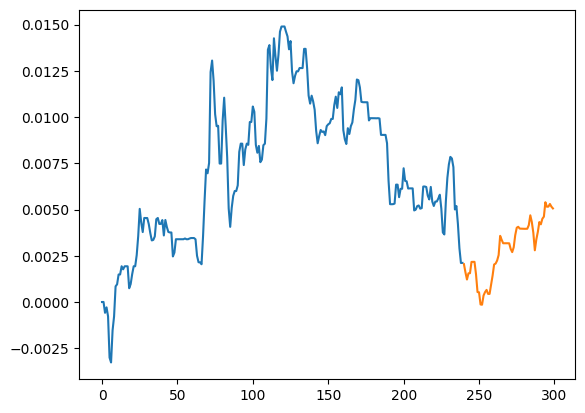

In [30]:
#plot random sample
rand_idx = np.random.randint(0, len(x))
plt.plot(np.arange(train_window_size), x[rand_idx,0,:].numpy())
plt.plot(np.arange(train_window_size, train_window_size+target_window_size), y[rand_idx,:].numpy())

In [31]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(num_input_chans, 32, 3, padding=1)
        self.conv2 = nn.Conv1d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv1d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv1d(32, 32, 3, padding=1)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(64)
        self.fc3 = nn.LazyLinear(target_window_size)
        
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(F.max_pool1d(x, 2))
        x = self.conv2(x)
        x = F.leaky_relu(F.max_pool1d(x, 2))
        x = self.conv3(x)
        x = F.leaky_relu(F.max_pool1d(x, 2))
        x = self.conv4(x)
        x = F.leaky_relu(F.max_pool1d(x, 2))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        
        return x
    
model = Model()
print(model(x).shape)    

torch.Size([64, 60])


c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

losses = []
def train(model, data, lr=.0001, epochs=10):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            y = y.to(device)
            opt.zero_grad()
            x_hat = model(x)
            loss = ((y - x_hat)**2).mean()
            loss.backward()
            opt.step()
            losses.append(loss)
            print(f'epoch: {epoch}, loss: {loss}', end='\r')
    return model

model = model.to(device) # GPU
train(model, train_dl, lr=0.001, epochs=100)

C:\Users\avido\AppData\Local\Temp\ipykernel_27756\4044232147.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


C:\Users\avido\AppData\Local\Temp\ipykernel_27756\4044232147.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].max() - 1


KeyboardInterrupt: 

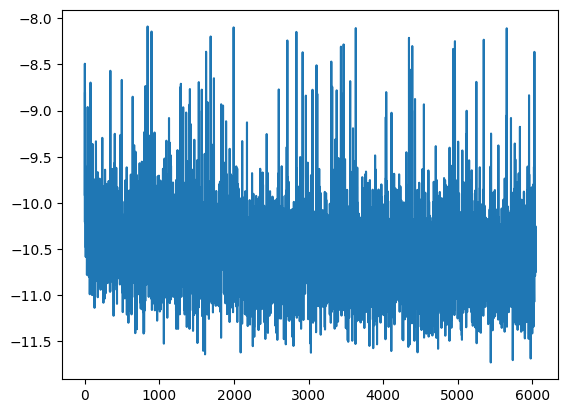

In [62]:
plt.plot([np.log(loss.cpu().detach().numpy()) for loss in losses])

In [63]:
#test on test set
model.eval()
test_losses = []
for x, y in test_dl:
    x = x.to(device) # GPU
    y = y.to(device)
    x_hat = model(x)
    loss = ((y - x_hat)**2).mean()
    test_losses.append(loss)
    print(f'loss: {loss}', end='\r')

print(f'average test loss: {np.mean(test_losses)}')

C:\Users\avido\AppData\Local\Temp\ipykernel_27756\4044232147.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


KeyboardInterrupt: 

C:\Users\avido\AppData\Local\Temp\ipykernel_27756\4044232147.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


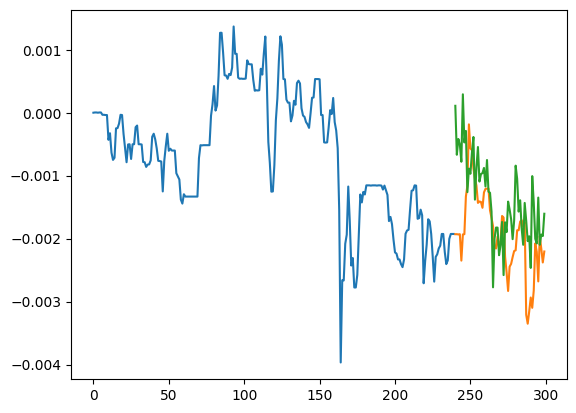

In [75]:
#plot an example
x, y = next(iter(test_dl))
rand_idx = np.random.randint(0, len(x))
plt.plot(np.arange(train_window_size), x[rand_idx,0,:].numpy())
plt.plot(np.arange(train_window_size, train_window_size+target_window_size), y[rand_idx,:].numpy())
plt.plot(np.arange(train_window_size, train_window_size+target_window_size), model(x[rand_idx,:,:].unsqueeze(0).to(device)).cpu().detach().numpy().squeeze())
